# 2-5. 프로젝트: SentencePiece 사용하기


# Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

[네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/) 가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요. (여러분들은 [fasttext](https://wikidocs.net/22883)로 사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는 형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다. 기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)

* 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
* 학습된 모델로 sp_tokenize() 메소드 구현하기
* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
* SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기



# 1. 네이버 영화리뷰 데이터 수집 (공통) 

In [1]:
#!cp -r ~/aiffel/sentiment_classification/data ~/aiffel/sp_tokenizer/data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import konlpy
from konlpy.tag import Mecab, Kkma, Okt, Komoran, Hannanum 
import gensim
from collections import Counter
import os,sys,copy,time
import seaborn as sns
import tqdm
import re
import urllib

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)
print(pd.__version__)
print(gensim.__version__)

2.6.0
1.21.4
0.5.2
1.3.3
4.1.2


In [2]:
url_train = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
url_test = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"

urllib.request.urlretrieve(url_train, filename="ratings_train.txt")
urllib.request.urlretrieve(url_test, filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fe9105be820>)

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table(r'~/aiffel/sp_tokenizer/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_test.txt')

print("train_data",train_data.head(),train_data.shape)
print('-'*60)
print("test_data",test_data.head(),test_data.shape)

train_data          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1 (150000, 3)
------------------------------------------------------------
test_data         id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0 (50000, 3)


# 2. SentencePiece 토크나이저 사용의 경우

* **(1) 데이터 기본적 전처리**

In [4]:
## 데이터로더
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
voca_size =10000

def load_and_preprocess_data(train_data, test_data, voca_size = voca_size):
    ## 중복값 제거:  'document'컬럼의 중복값 제거,'label'컬럼은 0,1의 두개면 맞음
    #1. train_data
    print("train_data['document'].nunique()",train_data['document'].nunique())
    if train_data['document'].nunique() < len(train_data):
        train_data.drop_duplicates(subset=['document'], inplace=True) 
        print("train_data['label'].nunique()",train_data['label'].nunique())    
        print("중복제거후 len(train_data)",len(train_data))    
    #2. test_data    
    print("test_data['document'].nunique()",test_data['document'].nunique())
    if test_data['document'].nunique() < len(test_data):
        test_data.drop_duplicates(subset=['document'], inplace=True)
        print("test_data['label'].nunique()",test_data['label'].nunique())    
        print("중복제거후 len(test_data)",len(test_data))
    
    ## 결측치제거 : 1개라도 있으면, 해당행 전체 제거
    #1. train_data
    print("결측치 개수",train_data.isnull().sum())
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",train_data.isnull().any().any())    
    #2. test_data
    print("결측치 개수",test_data.isnull().sum())
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",test_data.isnull().any().any())
    
    ## 데이터 정제 
    # 한글과 숫자,공백(한개이상 공백은 한개로 축소),특수문자일부 !?,.^을 제외하고 제거:[^ㄱ-힣a-zA-Z0-9!?,.^\s]
    # --> 한글형태소기를 tokenizer로 쓸 경우에는 영어및 일부선택된 특수문자외에는 모두제거(..., - - 등도 제거)
    #1. train_data
    train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
    train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ") 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                         
    print("한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()",train_data.head())
    #2. test_data
    test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
    test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ") 
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                            
    print("한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()",test_data.head())
    # 데이터 정제후 빈 공백만 있는 문장의 경우 제거:  Nan 입력후 행제거
    #1. train_data
    train_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",train_data.isnull().any().any() )
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
    #2. test_data   
    test_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",test_data.isnull().any().any() )
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
    
    # X_train , y_train, X_test, y_test    
    X_train = train_data['document']
    y_train = np.array(train_data['label'].tolist())
    X_test = test_data['document']
    y_test = np.array(test_data['label'].tolist())
    
    return X_train, y_train, X_test, y_test
    
        
X_train, y_train, X_test, y_test = load_and_preprocess_data(train_data, test_data)

# 전처리된 데이터 확인(불용어처리는 않되었슴, 형태소분석후 해야하는데, sentencepiece는 학습중에
# --> 처리될수도 있으나, 확실치 않으니, 결과를 반드시 확인해야함, 형태소분석을 해야하는 한국어인데,
# sentencepiece에서는 않해도 되는지 확인필요)
print("X_train[:5]",X_train[:5],"y_train[:5]",y_train[:5],"X_test[:5]",X_test[:5],"y_test[:5]",y_test[:5])



train_data['document'].nunique() 146182
train_data['label'].nunique() 2
중복제거후 len(train_data) 146183
test_data['document'].nunique() 49157
test_data['label'].nunique() 2
중복제거후 len(test_data) 49158
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False


/tmp/ipykernel_4462/3168550979.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_4462/3168550979.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_4462/3168550979.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()          id                                           document  label
0   9976970                                 아 더빙  진짜 짜증나네요 목소리      0
1   3819312                       흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                        교도소 이야기구먼  솔직히 재미는 없다 평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


/tmp/ipykernel_4462/3168550979.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_4462/3168550979.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ")


한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()         id                                        document  label
0  6270596                                             굳 ㅋ      1
1  9274899                                                      0
2  8544678             뭐야 이 평점들은  나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                     지루하지는 않은데 완전 막장임  돈주고 보기에는       0
4  6723715  3만 아니었어도 별 다섯 개 줬을텐데  왜 3로 나와서 제 심기를 불편하게 하죠??      0
Nan 존재유뮤 True
Nan 존재유뮤 True
X_train[:5] 0                                   아 더빙  진짜 짜증나네요 목소리
1                         흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                          교도소 이야기구먼  솔직히 재미는 없다 평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object y_train[:5] [0 1 0 0 1] X_test[:5] 0                                               굳 ㅋ
2               뭐야 이 평점들은  나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                       지루하지는 않은데 완전 막장임  돈주고 보기에는 
4    3만 아니었어도 별 다섯 개 줬을텐데  

/tmp/ipykernel_4462/3168550979.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


In [5]:
print("X_train.shape",X_train.shape,"y_train.shape",y_train.shape,"X_test.shape",X_test.shape,"y_test.shape",y_test.shape)

X_train.shape (146026,) y_train.shape (146026,) X_test.shape (49084,) y_test.shape (49084,)


**[체크필요]: 위에서 불용어처리는 않되었슴**
형태소분석후 해야하는데, Sentencepiece는 학습중에 처리될수도 있으나, 확실치 않으니, 결과를 반드시 확인해야함, 형태소분석을 해야하는 한국어인데,
Sentencepiece에서는 않해도 되는지 확인필요

#### (2) Sentencepiece 로 1차 Tokenizing
* **maxlen 지정전 train data 로 1차 Tokenizing 학습**

In [6]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_bpe.txt'
print(temp_file)

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in X_train: 
        f.write(str(row) + '\n')

## SentencePieceTrainer 실행: 1차 실행 (maxlen인자 없이)
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)   
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_bpe*

/aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_bpe.txt


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_bpe.txt --model_prefix=korean_spm_bpe --vocab_size=10000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_bpe.txt
  input_format: 
  model_prefix: korean_spm_bpe
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1


-rw-r--r-- 1 root root 410868 Feb 18 01:21 korean_spm_bpe.model
-rw-r--r-- 1 root root 152068 Feb 18 01:21 korean_spm_bpe.vocab


In [7]:
"""
input : 학습시킬 파일
model_prefix : 만들어질 모델 이름
vocab_size : 단어 집합의 크기
model_type : 사용할 모델 (unigram(default), bpe, char, word)
max_sentence_length: 문장의 최대 길이
pad_id, pad_piece: pad token id, 값
unk_id, unk_piece: unknown token id, 값
bos_id, bos_piece: begin of sentence token id, 값
eos_id, eos_piece: end of sequence token id, 값
user_defined_symbols: 사용자 정의 토큰
"""

'\ninput : 학습시킬 파일\nmodel_prefix : 만들어질 모델 이름\nvocab_size : 단어 집합의 크기\nmodel_type : 사용할 모델 (unigram(default), bpe, char, word)\nmax_sentence_length: 문장의 최대 길이\npad_id, pad_piece: pad token id, 값\nunk_id, unk_piece: unknown token id, 값\nbos_id, bos_piece: begin of sentence token id, 값\neos_id, eos_piece: end of sequence token id, 값\nuser_defined_symbols: 사용자 정의 토큰\n'

In [8]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[7014, 8666, 8419, 1382, 8415, 8514, 8408, 8411]
['▁아버지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


* **sp_tokenize_noPadding 함수 생성**

In [9]:
def sp_tokenize_noPadding(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_bpe.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen= maxlen, padding='post')

    return tensor, word_index, index_word

In [10]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize_noPadding(s, my_corpus)
print(tensor)

[[710, 2598, 8432, 571, 835, 8411], [1482, 2396, 295, 7755, 141, 9664, 12, 8411, 8411, 8411]]


* **1차 학습된 spm으로 sp_tokenize함수를 통해 X_train,  X_test 각각 토크나이징**

In [11]:
# X_train, y_train, X_test, y_test

# Tokenizing: X_train 
X_train_tensor, X_train_word_index, X_train_index_word = sp_tokenize_noPadding(s, X_train)
print("X_train_tensor[:10]",X_train_tensor[:10])

# Tokenizing: X_test 
X_test_tensor, X_test_word_index, X_test_index_word = sp_tokenize_noPadding(s, X_test)
print("X_test_tensor[:10]",X_test_tensor[:10])

X_train_tensor[:10] [[6, 1031, 51, 2279, 39, 2000], [1470, 984, 164, 1228, 3, 8622, 2747, 291, 1684, 1841, 8412, 63, 409], [21, 8441, 9932, 110, 6455, 439, 1192, 2080, 284], [581, 8417, 8507, 286, 7714, 494, 1350, 231, 66, 121, 8449], [1647, 9193, 8964, 8440, 8424, 3034, 8620, 1859, 643, 1642, 2146, 4, 8435, 8443, 1774, 5511, 44, 2214, 8425, 2198, 1145, 2375, 1099, 7164, 2691, 565, 8415, 2154, 2953, 8423, 380], [319, 404, 8461, 8452, 8406, 0, 197, 8537, 265, 5428, 36, 3062, 8485, 8439, 488, 8620, 8534, 3, 8411, 357, 4477, 1283, 1654, 8411], [3464, 6203, 671, 4002, 8464, 2175, 232, 8411], [101, 3701, 411, 7286, 5, 9038, 8645, 879, 8534, 8473, 53, 4249, 8407, 8797, 8593, 414, 37, 3132, 774, 2849, 1009, 1069, 2336, 2984, 8528, 8411, 8467, 8581, 8426, 8562, 8733, 8562, 8733, 4600, 8409, 567, 8417, 399, 53, 5767, 337, 8426, 8505, 9127, 8457], [2412, 3339, 8417, 27, 207, 449, 1991, 4], [3291, 289, 1498, 1356, 8460, 1038, 376, 918, 2875, 8661, 1304, 8548, 2896, 21, 879, 5288, 8734, 2708, 8460

#### (3) 적절한 최대 문장 길이 지정: (평균 + 표준편차*2)이내: maxlen 42 개**

문장길이평균: 15.41
문장길이표준편차: 13.4
문장길이Max: 111
문장길이Min: 0
문장길이 0개수: 308
['sans-serif']


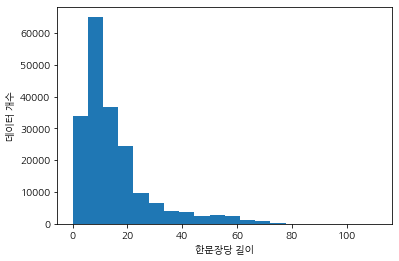

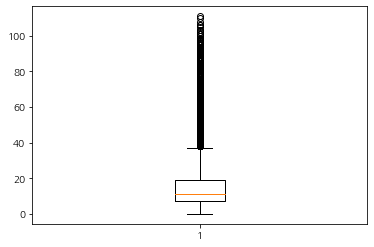

maxlen 42


In [12]:
## 데이터셋 내 문장 길이 분포
total_data_text = list(X_train_tensor) + list(X_test_tensor)
total_data_text_dist = [len(x) for x in total_data_text]
#print(total_data_text_dist)

mean = round(np.mean(total_data_text_dist),2)
std = round(np.std(total_data_text_dist),2)
max = np.max(total_data_text_dist)
min = np.min(total_data_text_dist)
min_count = len([x for x in total_data_text_dist if x == 0])
print("문장길이평균:",mean)
print("문장길이표준편차:",std)
print("문장길이Max:",max)
print("문장길이Min:",min)
print("문장길이 0개수:", min_count)

# 히스토그램 시각화: total_data
print(plt.rcParams['font.family'])
plt.rc('font',family='NanumGothic')
plt.hist(total_data_text_dist, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

# 박스플롯: total_data
plt.boxplot(total_data_text_dist)
plt.show()

## 적절한 최대 문장 길이 지정: (평균 + 표준편차*2)
maxlen = int(mean + 2*std)
print("maxlen", maxlen)

#### (4) Sentencepiece 로  최종 Tokenizing
* **maxlen 지정후 train data 로 최종 Tokenizing 학습** 

In [14]:
import sentencepiece as spm

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_bpe_new.txt'
print(temp_file)

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in X_train: 
        f.write(str(row) + '\n')

## SentencePieceTrainer 실행: 1차 실행 (maxlen인자 없이)
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_new --vocab_size={} --max_sentence_length={} --model_type=bpe'.format(
        temp_file, vocab_size, maxlen)   
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_bpe*

/aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_bpe_new.txt
-rw-r--r-- 1 root root 410868 Feb 18 01:21 korean_spm_bpe.model
-rw-r--r-- 1 root root 409870 Feb 18 01:38 korean_spm_bpe_new.model
-rw-r--r-- 1 root root 151059 Feb 18 01:38 korean_spm_bpe_new.vocab
-rw-r--r-- 1 root root 152068 Feb 18 01:21 korean_spm_bpe.vocab


In [15]:
## 새롭게 학습한 모델로 s 객체 변경:및 new 모델로드  SentencePieceProcessor()
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_new.model')

True

* **sp_tokenize_withPadding 함수 생성**

In [16]:
def sp_tokenize_withPadding(s, corpus, maxlen):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_bpe_new.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen= maxlen, padding='post')

    return tensor, word_index, index_word

* **최종 학습된 spm으로 sp_tokenize함수를 통해 X_train,  X_test 각각 토크나이징**

In [17]:
# X_train, y_train, X_test, y_test

# Tokenizing: X_train 
X_train_tensor, X_train_word_index, X_train_index_word = sp_tokenize_withPadding(s, X_train, maxlen)
print("X_train_tensor[:10]",X_train_tensor[:10])

# Tokenizing: X_test 
X_test_tensor, X_test_word_index, X_test_index_word = sp_tokenize_withPadding(s, X_test, maxlen)
print("X_test_tensor[:10]",X_test_tensor[:10])

X_train_tensor[:10] [[   7 1090   27 1426   31 3323    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 594  771  232 1167    3 8573 3545  343 2172 1621 8325  142  309    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  19 8320 9501  112 1669 8368  539 3183 1291  321    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 792 8336 8443  390 2807  406  853  144   39 3280    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [2877 9097 8898 8353 8334 2481 8602 1735  770 1891 2832    4 8316 8359
  1811 4606  175 2473 8025  916 3928 166

* **토크나이징 최종완료후 데이터 shape 확인**

In [18]:
print("X_train_tensor.shape",X_train_tensor.shape,"y_train.shape",y_train.shape,"X_test_tensor.shape",X_test_tensor.shape,"y_test.shape",y_test.shape)


X_train_tensor.shape (146026, 42) y_train.shape (146026,) X_test_tensor.shape (49084, 42) y_test.shape (49084,)


#### (5) 모델 구성 및 validation set 구성¶

In [19]:
## Hyper param 설정
vocab_size = len(X_train_word_index)   # 어휘 사전의 크기(8000 )#10,000개의 단어)

word_vector_dim = 16  # 워드 벡터의 차원 수
hidden_unit = 16
drop_rate = 0.2
epochs= 20 

#cnn_dense_hidden_unit = 8
#cnn_filter = 7
#cnn_maxpool = 4
epochs= 20 


* **LSTM 모델**

In [20]:
## LSTM 모델

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.LSTM(hidden_unit)) 
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.Dense(hidden_unit, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 162,401
Trainable params: 162,401
Non-trainable params: 0
__________________________________________________

* **valid data 분리**

In [21]:
## 총 train data : 80:20 
print("X_train_tensor 총개수:", len(X_train_tensor), "80%분리: ",int(len(X_train_tensor)*0.8), "20%분리:",len(X_train_tensor)-int(len(X_train_tensor)*0.8))
train_len = int(len(X_train_tensor)*0.8)
valid_len = len(X_train_tensor)-int(len(X_train_tensor)*0.8)

# validation set 20% 분리: 
X_val_tensor = X_train_tensor[:valid_len]   
y_val = y_train[:valid_len]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train_tensor[valid_len:]  
partial_y_train = y_train[valid_len:]

print("partial_X_train",len(partial_X_train),"partial_y_train",len(partial_y_train))
print("X_val_tensor",len(X_val_tensor), "y_val",len(y_val))

X_train_tensor 총개수: 146026 80%분리:  116820 20%분리: 29206
partial_X_train 116820 partial_y_train 116820
X_val_tensor 29206 y_val 29206


#### (6) LSTM모델 학습

In [22]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
  
history_lstm = model_lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_tensor, y_val), verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.6667 - accuracy: 0.5525 - val_loss: 0.4508 - val_accuracy: 0.7997
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3806 - accuracy: 0.8342 - val_loss: 0.3473 - val_accuracy: 0.8489
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3299 - accuracy: 0.8599 - val_loss: 0.3438 - val_accuracy: 0.8495
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3158 - accuracy: 0.8661 - val_loss: 0.3409 - val_accuracy: 0.8512
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3071 - accuracy: 0.8705 - val_loss: 0.3550 - val_accuracy: 0.8524
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2986 - accuracy: 0.8739 - val_loss: 0.3357 - val_accuracy: 0.8535
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2904 - accuracy: 0.8764 - val_loss: 0.3434 - val_accuracy: 0.8487
Epoch 

* **SentencePiece의 경우 LSTM Loss, Accuracy 시각화**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


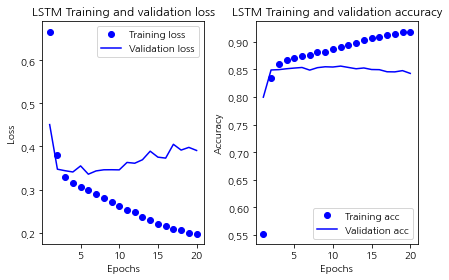

In [23]:
history_lstm = history_lstm.history
print(history_lstm.keys()) 

acc = history_lstm['accuracy']
val_acc = history_lstm['val_accuracy']
loss = history_lstm['loss']
val_loss = history_lstm['val_loss']

epochs = range(1, len(acc) + 1)

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACCURACY
#plt.clf()   # 그림을 초기화합니다
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### (7) test data 로 모델 성능평가

In [24]:
## LSTM 모델 성능평가
results_lstm = model_lstm.evaluate(X_test_tensor,  y_test, verbose=2)

print("results_lstm", results_lstm)

1534/1534 - 3s - loss: 0.4066 - accuracy: 0.8364
results_lstm [0.4065810739994049, 0.8363621830940247]


#### [평가] SentencePiece의 경우 LSTM test accuracy 83.64% 였슴